In [1]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
import os.path
import copy
import cv2 as cv

# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
# On a 30 * 30 abdomens + 20 * 30 labelisés au total
RELOAD_DATA = False
nb_dirs_to_load = 1000 # 50 folders total, bigger number means load all
nb_files_to_load_per_dir = 5 # putting a number bigger than the number of files will just load every file in the folder

# if true, retrain model
DO_WE_LEARN = False
epochs = 20
file_name = "model_simple_3D.hdf5"

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

d:\abdomen_segmentation\single_organ_segmentation


In [2]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for j in range(1):
        patient = img[j]
        for i in range(45, 100, 10):
            disp_list.append(patient[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -100, 100)

In [3]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    raw_patient = []
    labeled_patient = []
    labeled_scan = np.where(labeled_scan == 6, 1, 0).astype('uint8')
    for i in range(scan.shape[2]):
        if labeled_scan[:, :, i].sum() == 0:
            continue
        
        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)

        raw_patient.append(resized_data)
        labeled_patient.append(resized_data_labeled)

    raw_patient = np.array(raw_patient)
    labeled_patient = np.array(labeled_patient)

    # now fill or crop arrays until size 96 (necessary to reduce datasize and avoid OOM errors)
    s, sx, sy, sz = raw_patient.shape
    if s < 96:
        pair = False
        while(raw_patient.shape[0] < 96):
            if pair:
                raw_patient = np.append(raw_patient, np.zeros((1, sx, sy, sz)), axis=0)
                labeled_patient = np.append(labeled_patient, np.zeros((1, sx, sy, sz)), axis=0)
            else:
                raw_patient = np.insert(raw_patient, 0, np.zeros((1, sx, sy, sz)), axis=0)
                labeled_patient = np.insert(labeled_patient, 0, np.zeros((1, sx, sy, sz)), axis=0)
            pair = not pair
    elif s > 96:
        diff = s - 96
        left_half_diff = diff//2
        right_half_diff = diff - left_half_diff
        raw_patient = raw_patient[left_half_diff:(s - right_half_diff), :, :, :]
        labeled_patient = labeled_patient[left_half_diff:(s - right_half_diff), :, :, :]

    raw_data.append(raw_patient)
    labeled_data.append(labeled_patient)

unique : [-5.9728785 -5.9681253 -5.9617662 ...  6.442156   6.4587812  6.467688 ]
Data shape  : (150, 96, 160, 112, 1)
Label shape : (150, 96, 160, 112, 1)
Raw data type     : float32
Labeled data type : uint8


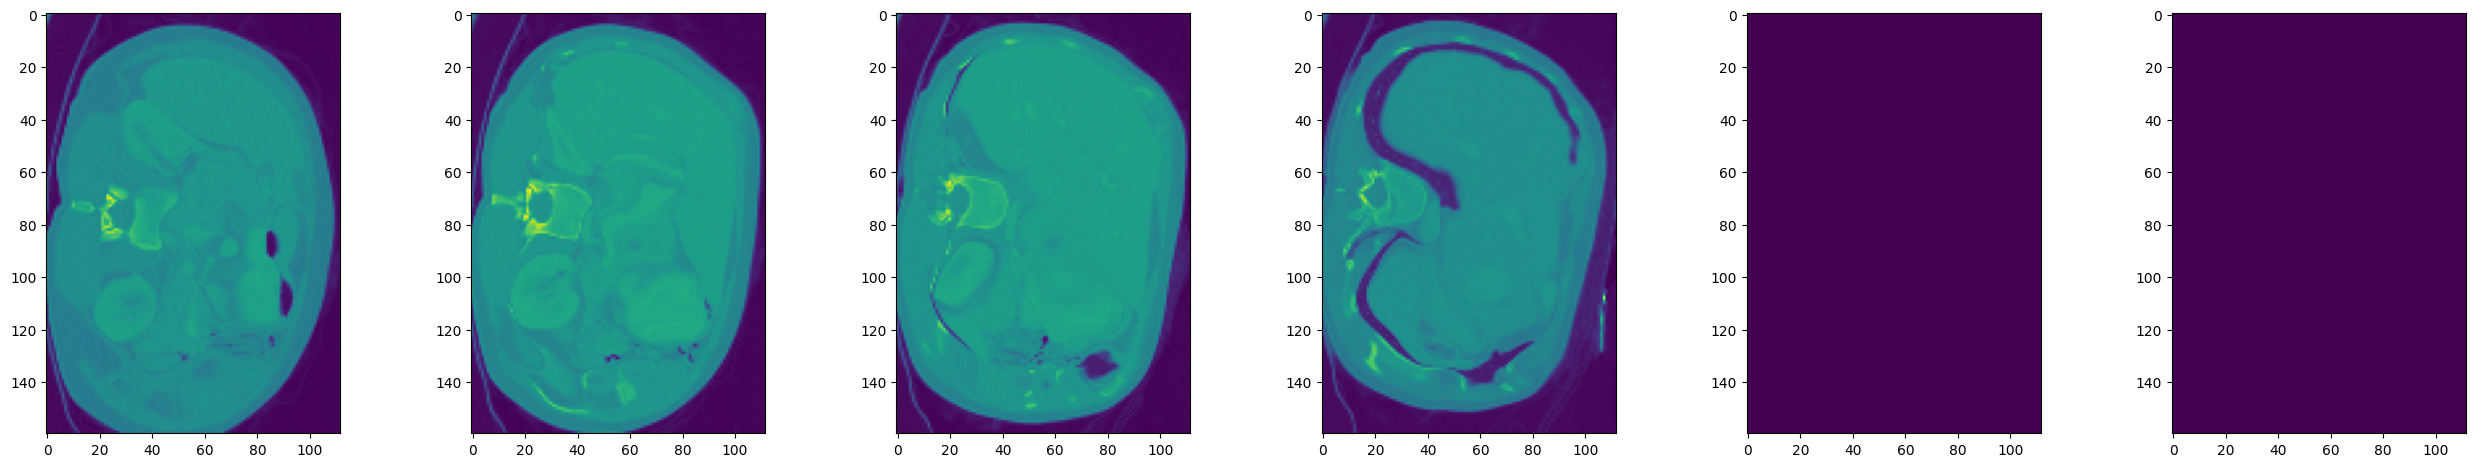

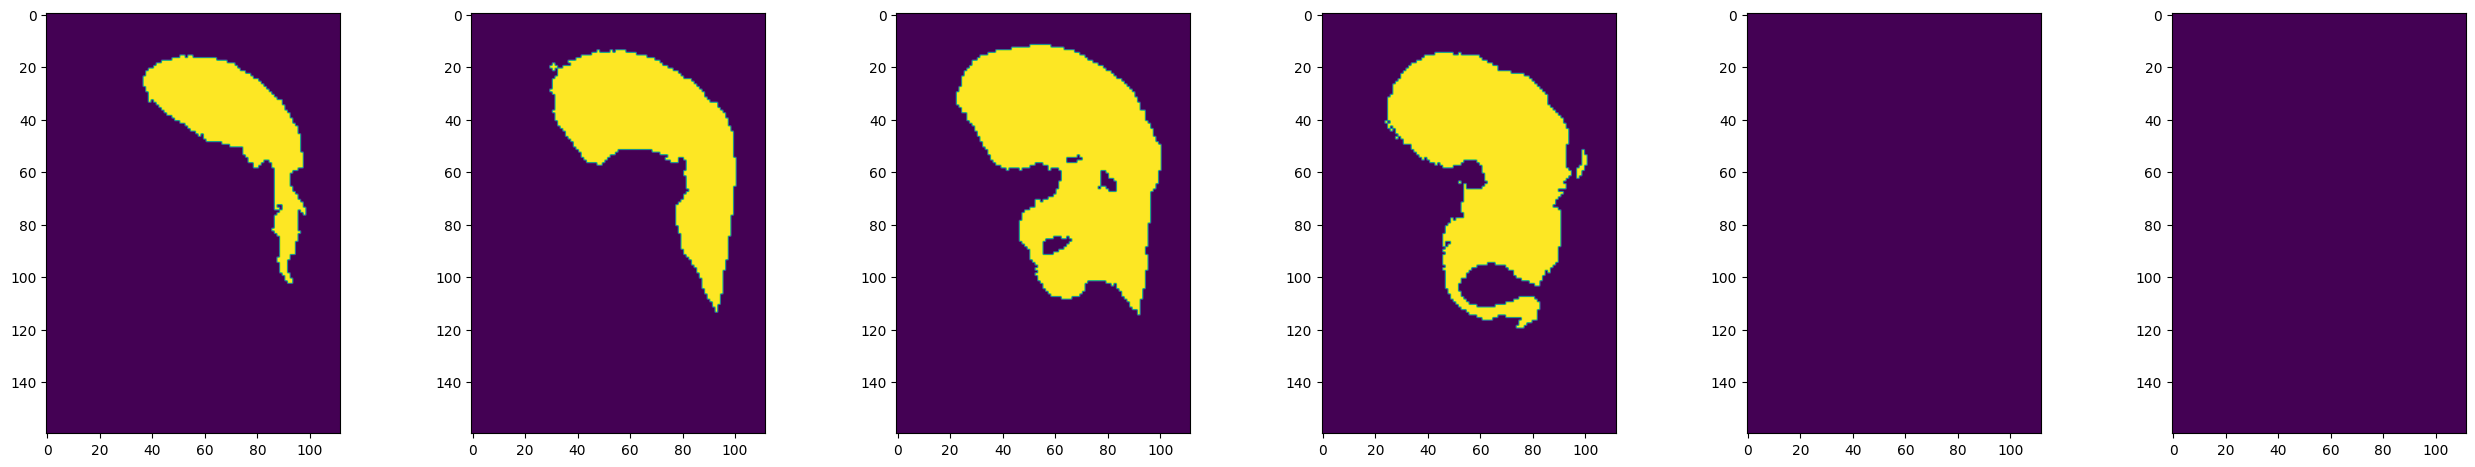

In [4]:
if RELOAD_DATA:
    loaded_dirs = 0
    for _, dirs, filenames in os.walk("../data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("../data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "../data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "../data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("../numpy_arrays/raw_liver_data_3D.npy", raw_data)
    np.save("../numpy_arrays/labeled_liver_data_3D.npy", labeled_data)
else:
    raw_data = np.load("../numpy_arrays/raw_liver_data_3D.npy")
    labeled_data = np.load("../numpy_arrays/labeled_liver_data_3D.npy")

raw_data = np.expand_dims(raw_data[:, :, :, :, 0], axis=4)
print(f"unique : {np.unique(raw_data)}")
print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print_slices(raw_data)
print_slices(labeled_data)

In [5]:
# ---- 3D UNET ----
from att_unet import dice_coef, dice_coef_loss

_, sx, sy, sz, sk = raw_data.shape

nbf64 = 4
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet(input_size = (sx, sy, sz, 1)):
    inputs = Input(input_size)
    conv1 = Conv3D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    pool1 = MaxPooling3D(pool_size = (2, 2, 2))(conv1)

    conv2 = Conv3D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    pool2 = MaxPooling3D(pool_size = (2, 2, 2))(conv2)

    conv3 = Conv3D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    pool3 = MaxPooling3D(pool_size = (2, 2, 2))(conv3)

    conv4 = Conv3D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size = (2, 2, 2))(conv4)

    conv5 = Conv3D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 4)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 4)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 4)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 4)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model = unet(input_size = (sx, sy, sz, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 160, 11  0           []                               
                                2, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 96, 160, 112  112         ['input_1[0][0]']                
                                , 4)                                                              
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 48, 80, 56,   0           ['conv3d[0][0]']                 
                                4)                                                            

xtrain shape      : (120, 96, 160, 112, 1)
ytrain shape      : (120, 96, 160, 112, 1)
xvalidation shape : (15, 96, 160, 112, 1)
yvalidation shape : (15, 96, 160, 112, 1)
xtest shape       : (15, 96, 160, 112, 1)
ytest shape       : (15, 96, 160, 112, 1)


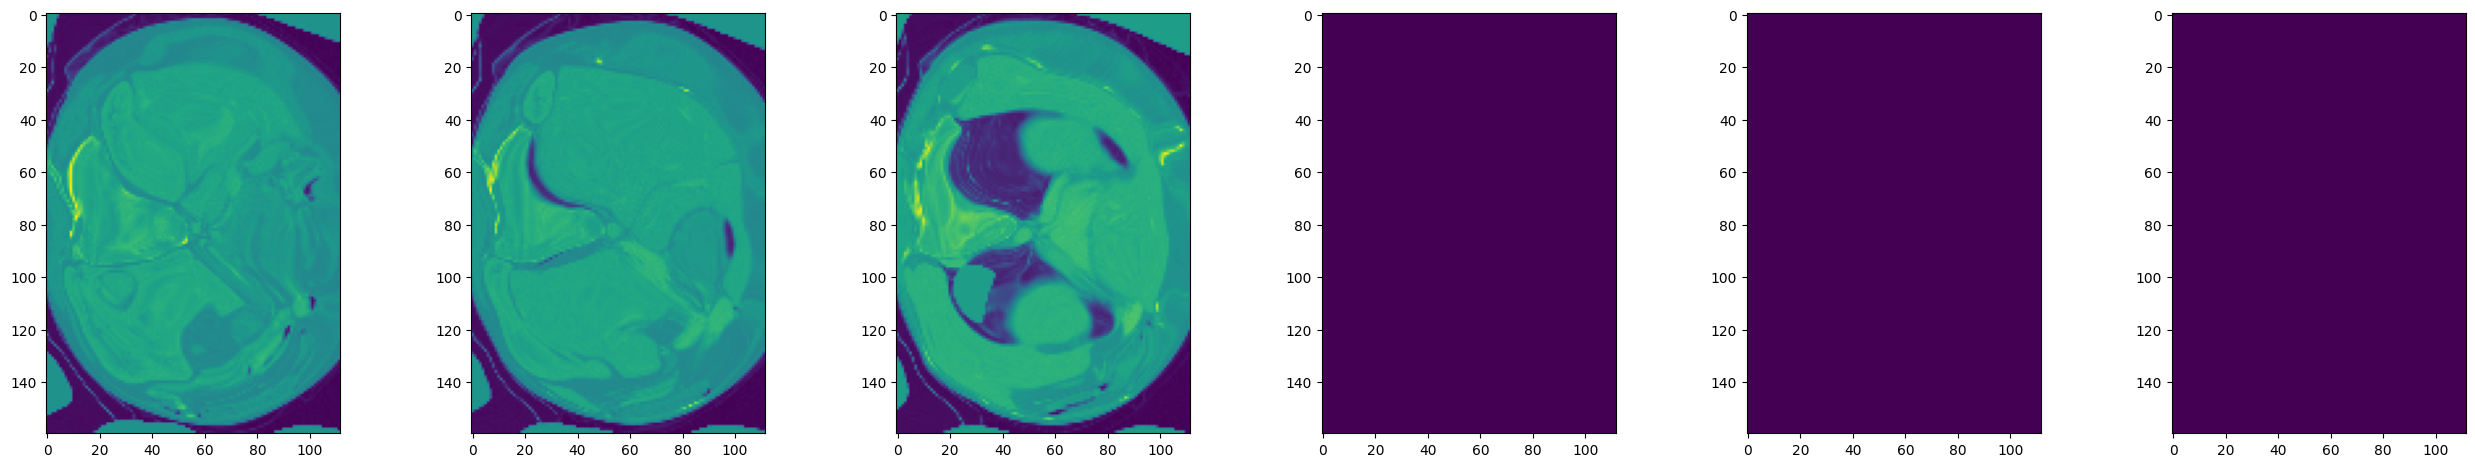

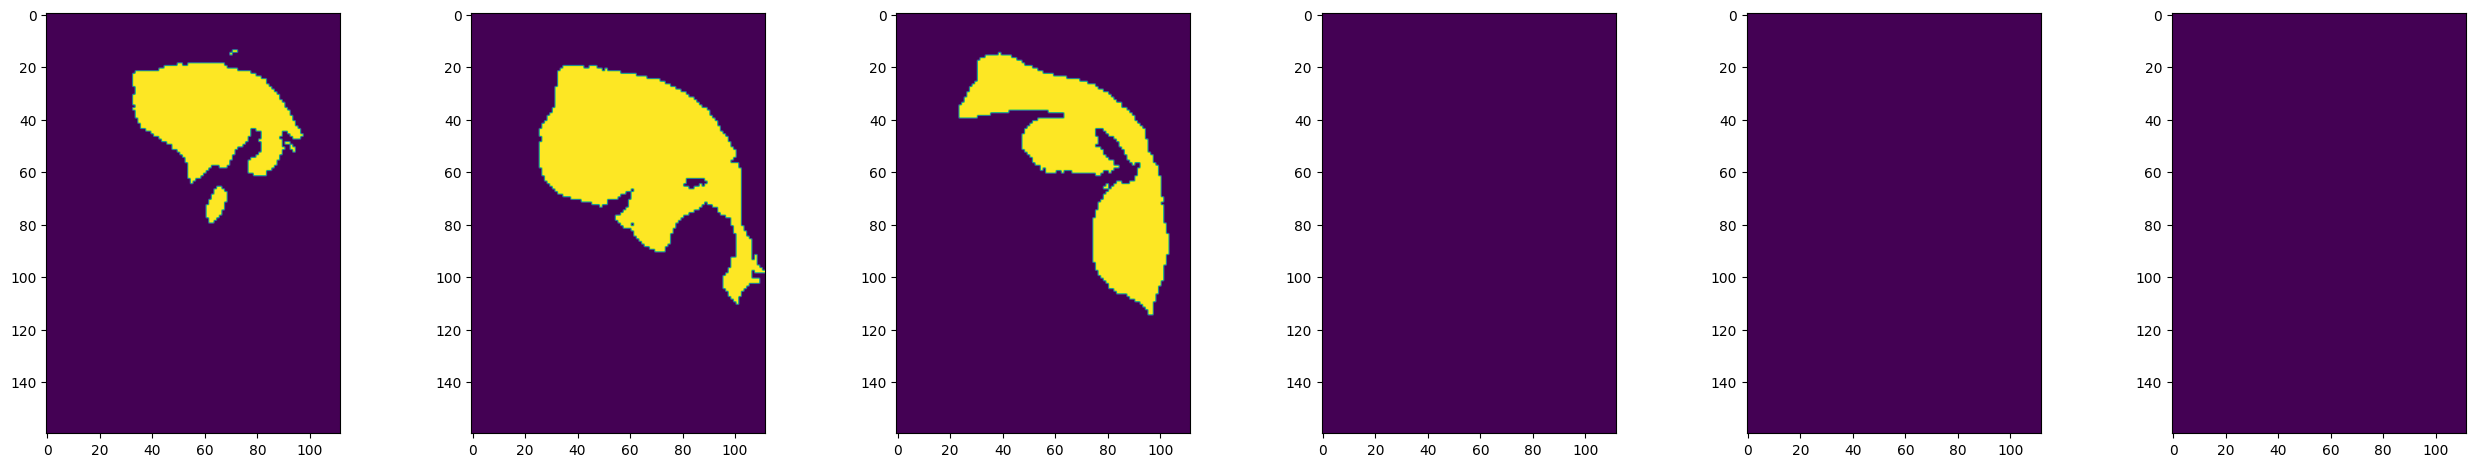

In [6]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))


print_slices(xtest)
print_slices(ytest)

In [7]:
# ---- entrainement ----

print("xtrain      : " + str(xtrain.shape))
print("ytrain      : " + str(ytrain.shape))
print("xvalidation : " + str(xvalidation.shape))
print("yvalidation : " + str(yvalidation.shape))

if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 1,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights(file_name)
else:
    model.load_weights(file_name)

xtrain      : (120, 96, 160, 112, 1)
ytrain      : (120, 96, 160, 112, 1)
xvalidation : (15, 96, 160, 112, 1)
yvalidation : (15, 96, 160, 112, 1)


In [8]:
xtest = xtest[:2, :, :, :, :]
ytest = ytest[:2, :, :, :, :]
prediction = model.predict(xtest)

1/1 [==============================] - 7s 7s/step


(2, 96, 160, 112, 1)
(2, 96, 160, 112, 1)


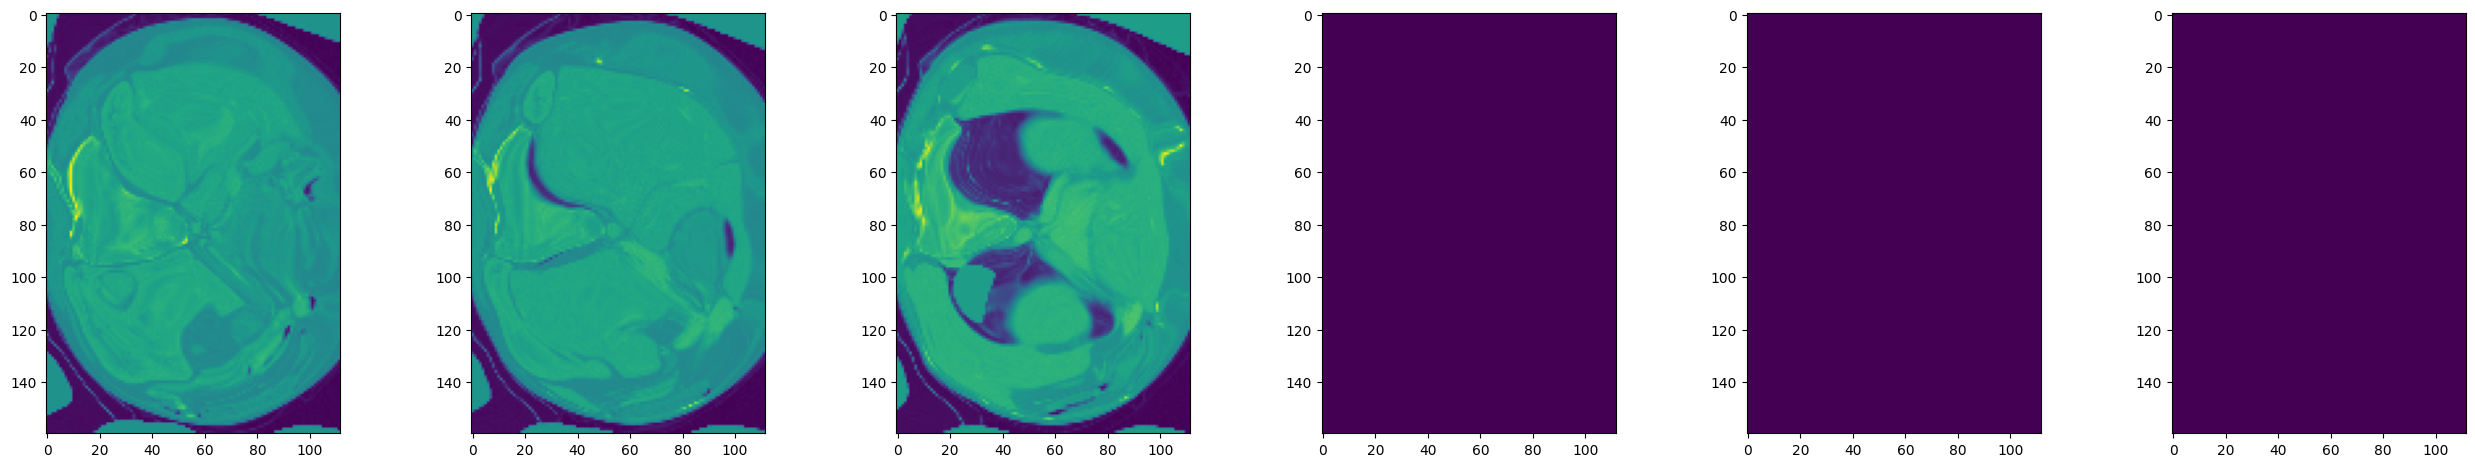

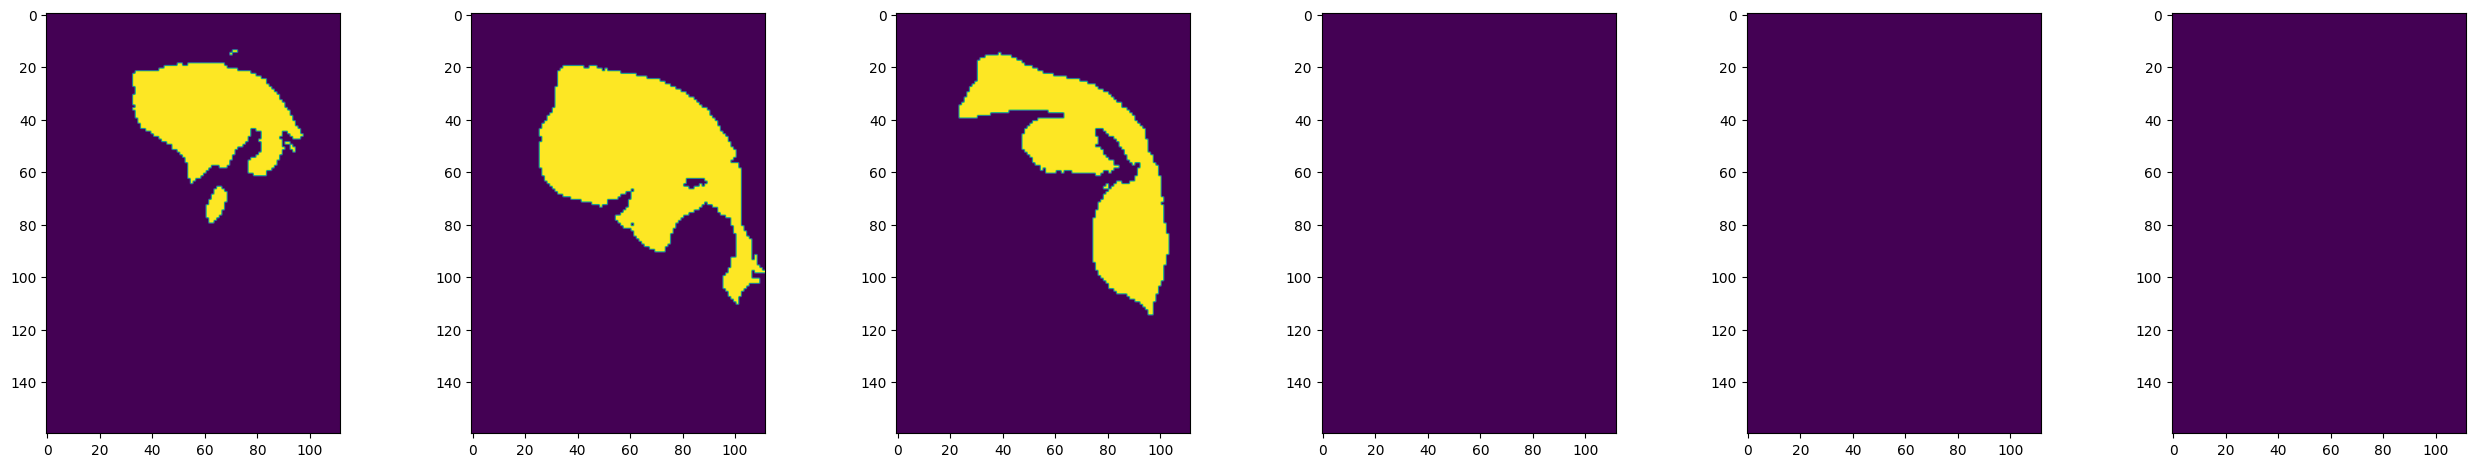

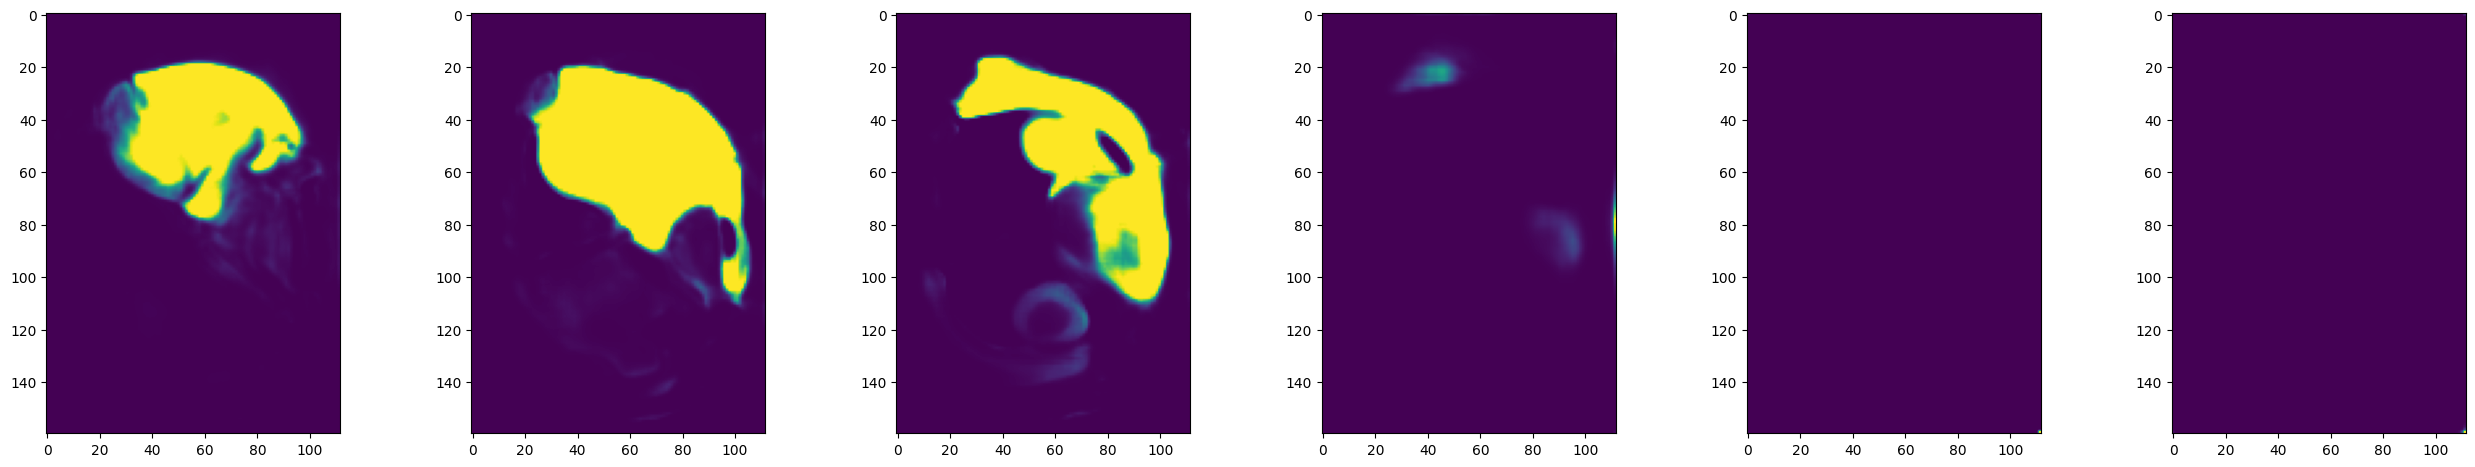

In [9]:
print(xtest.shape)
print(ytest.shape)
print_slices(xtest)
print_slices(ytest)
print_slices(prediction)

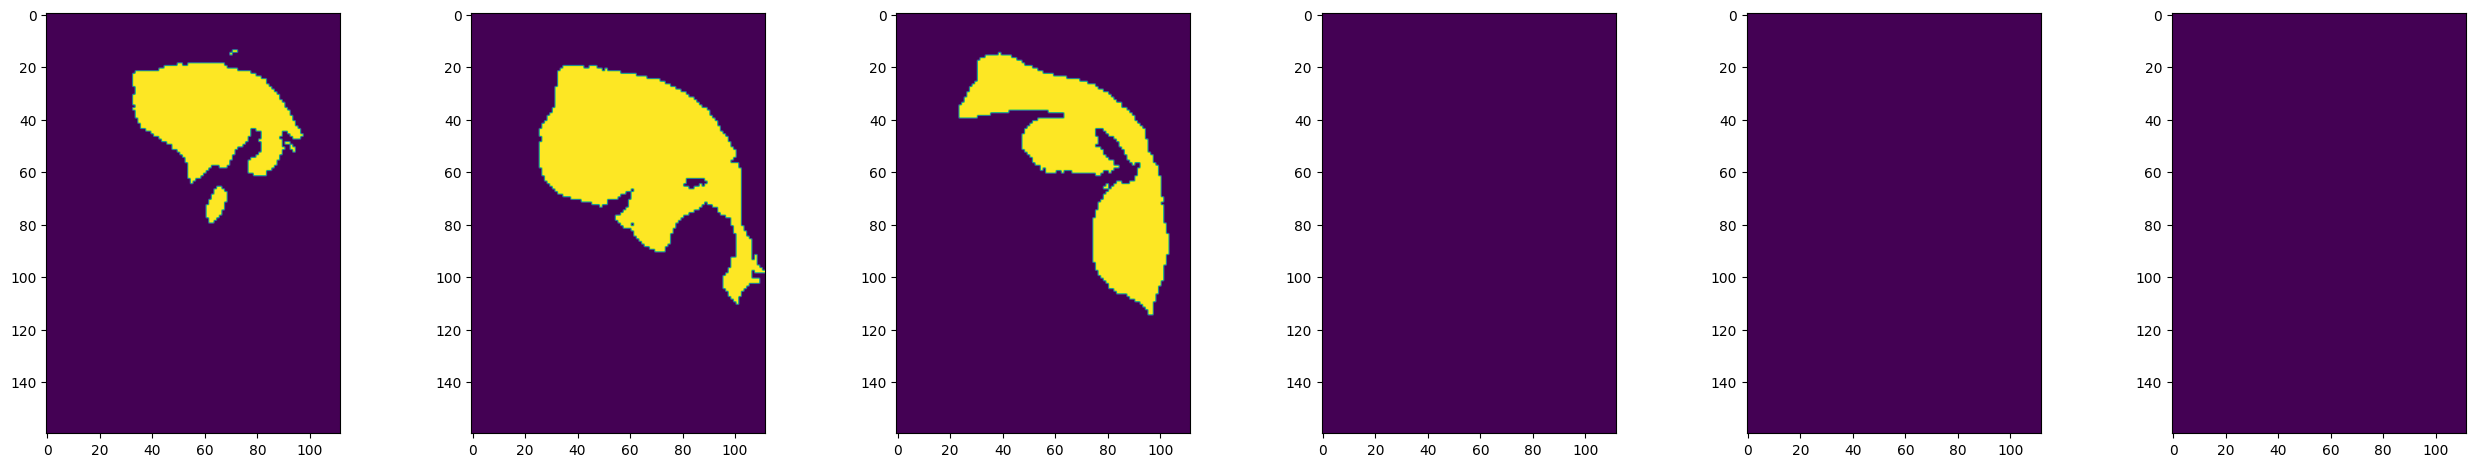

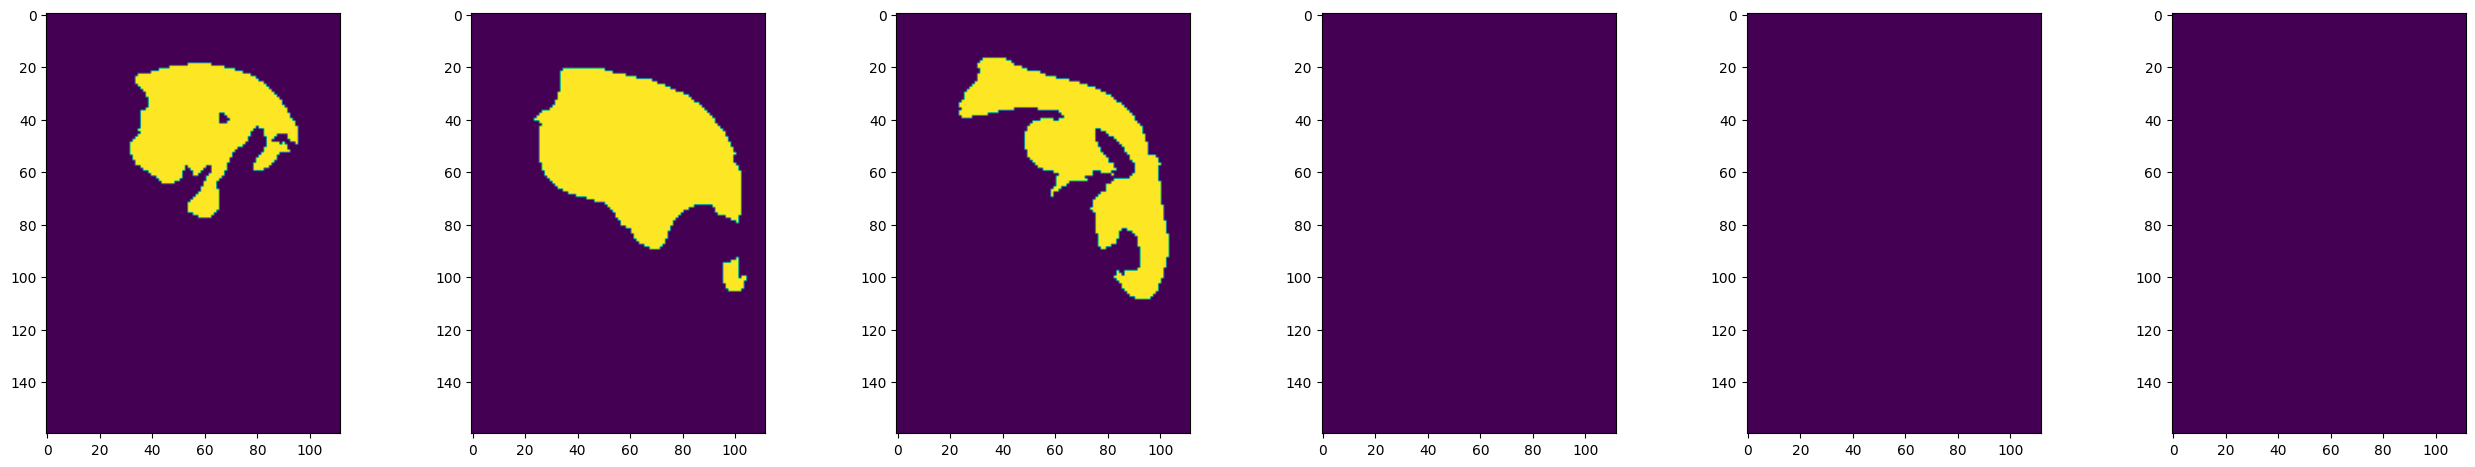

cardIntersec =  143374
cardX =  168486
cardY =  184165
dice =  0.8131211878032389


In [11]:
rounded_prediction = np.round(prediction)
print_slices(ytest)
print_slices(rounded_prediction)
dice = compute_dice(rounded_prediction, ytest)